In [2]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import random
from scipy.optimize import minimize
import warnings
from scipy.stats import linregress

# Funckja f(x)

In [3]:
def f(x) -> float:
    return np.sin(x * np.pi) + np.power(x, 2)

In [4]:
def f_grad(x) -> float:
    return np.pi*np.cos(x*np.pi) + 2*x

#### Na początku sprawdzam minimum globalne funkcji `f(x)` za pomocą biblioteki `scipy.optimize` aby porównać wyniki z mojej implementacji

In [5]:
min_f = minimize(f, 0, method='BFGS')
print("Minimum globalne funkcji f(x): ", min_f.x)

Minimum globalne funkcji f(x):  [-0.4149116]


In [6]:
def draw_2D_plot(function, domain, number_of_points) -> None:
    x = np.linspace(domain[0], domain[1], number_of_points)
    y = [function(x_val) for x_val in x]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(x, y, color='blue', linewidth=2, label='f(x)=sin(xπ)+x^2')
    ax.set_title('2D Plot of f(x)')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.show()

**Obserwacja wykresu funkcji f(x):**

Funkcja `f(x)` jest funkcją jednej zmiennej. Posiada `jedno` globalne minimum położone niedaleko punktu `x = -0.5`. Zoptymalizowanie funkcji algorytmem najszybszego spadku może wymagać dokładnego dobrania punktu początkowego algorytmu oraz dobrego rozmiaru skoku. W przypadku nieodpowiedniego punktu początkowego lub zbyt dużego skoku algorytm może zbiegać do ekstremum lokalnego.

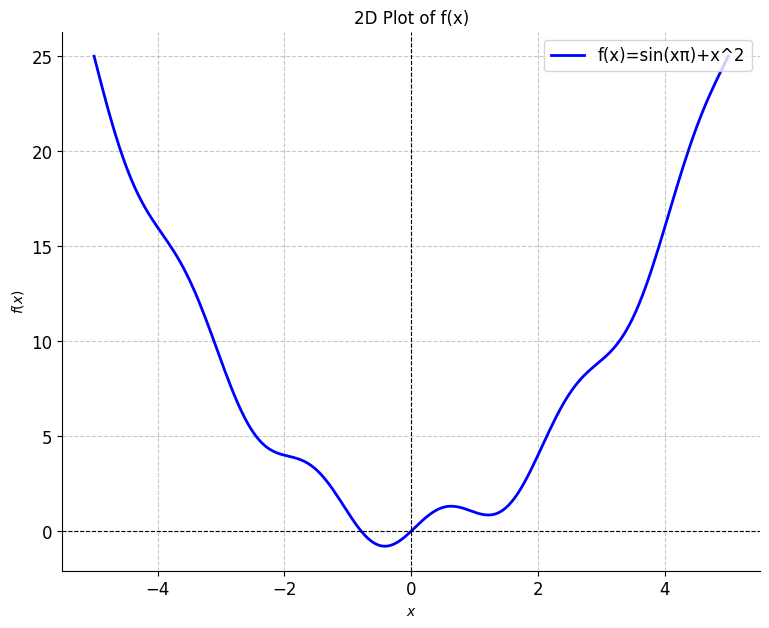

In [7]:
draw_2D_plot(f, (-5, 5), 200)

# Funckja g(x_i)

In [8]:
def g(x_i) -> float:
    return 5*np.power(np.e, 2) - 4*np.e*x_i[0] + np.power(x_i[0], 2) + 2*np.e*x_i[1] + np.power(x_i[1], 2)

In [9]:
def g_grad(x_i) -> np.array:
    return np.array([-4*np.e + 2*x_i[0], 2*np.e + 2*x_i[1]])

#### Na początku sprawdzam minimum globalne funkcji `g(x_i)` za pomocą biblioteki `scipy.optimize` aby porównać wyniki z mojej implementacji

In [10]:
min_g = minimize(g, [0, 0], method='BFGS')
print("Minimum globalne funkcji g(x_i): ", min_g.x)

Minimum globalne funkcji g(x_i):  [ 5.43656366 -2.7182818 ]


In [11]:
def draw_3D_plot(function, x1_domain, x2_domain, number_of_points) -> None:
    x1 = np.linspace(x1_domain[0], x1_domain[1], number_of_points)
    x2 = np.linspace(x2_domain[0], x2_domain[1], number_of_points)
    x1, x2 = np.meshgrid(x1, x2)
    y = function(np.array([x1, x2]))
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x1, x2, y, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax.view_init(40, 20)
    ax.set_xlabel('$x_{0}$')
    ax.set_ylabel('$x_{1}$')
    ax.set_zlabel('$f(x)$')
    cbar = fig.colorbar(ax.plot_surface(x1, x2, y, cmap='viridis'), ax=ax, shrink=0.5, aspect=10)
    plt.title('3D Plot of g(x)')
    ax.grid(True)
    ax.light_sources = 'lightsource'
    plt.show()


**Obserwacja wykresu funkcji g(x_i):**

Funkcja `g(x_i)` jest funkcją dwuwymiarową. `xi` oznacza i-ty element wektora x. Na pierwszy rzut oka funkcja maleje w jednym wyraźnym kierunku. Minimum globalne powinno znaleźć się w okolicy `x1 = 5`, `x2 = -3`. Zoptymalizowanie funkcji algorytmem najszybszego spadku będzie wymagać trudniejszego algorytmu ze względu na większą liczbę wymiarów. Jednak nie powinno być problemu zbiegania do ekstremum lokalnego.

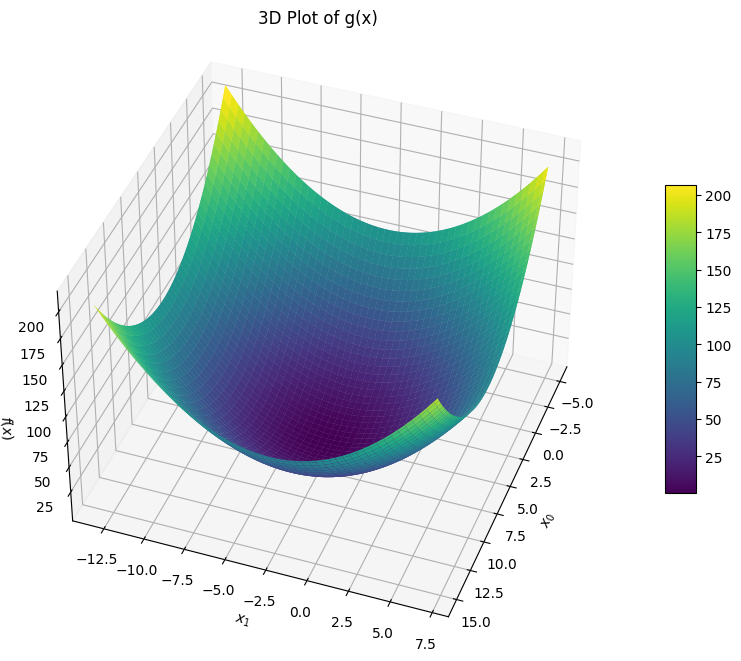

In [12]:
draw_3D_plot(g, (-5, 15), (-13, 7), 100)

# Moja implementacja algorytmu najszybszego spadku

**Implementacja warunku armijo**

Tutaj wytłumaczenie czym jest warunek armijo i jak go zaimplementowałem

In [13]:
def armijo_condition(function, step, x, gradient_x) -> float:
    c = 1e-4
    tol = 1e-6
    gradient_square_norm = np.linalg.norm(gradient_x)**2
    while function(x - step * gradient_x) >= (function(x) - c * step * gradient_square_norm):
        step /= 2
        if step < tol:
            break
    return step

**Moja implementacja algorytmu najszybszego spadku:**

Do funkcji przekazuję następujące argumenty:
* `x0` - wektor początkowy od którego rozpoczynamy poszukiwanie minimum (float lub lista floatów)
* `function` - funkcja, której minimum globalne poszukujemy
* `gradient` - gradient funkcji `function`
* `alpha` - rozmiar skoku (float)
* `epsilon` - zmienna decydująca o tym, że funkcja znalazła minimum (lokalne lub globalne) (float)
* `max_iter` - maksymalna liczba iteracji dozwolona do przeprowadzenia (int)
* `armijo` - zmienna decydująca czy używamy warunku armijo czy nie (bool)

Funckja zaczyna iterować i na podstawie wektora `x`, `alpha` oraz `gradientu` wyznacza kolejny wektor `x_next`. Gdy użytkownik zechce może aktywować dostosowywanie rozmiaru skoku `alpha` za pomocą warunku armijo. Następnie zostają obliczone różnice w wartościach funkcji oraz gradientach funkcji dla wektora `x` oraz wektora `x_next`. Jeśli różnica w wartościach funkcji oraz gradientu jest mniejsza od `epsilon` to oznacza, że zostało znalezione ekstremum. Jeśli liczba iteracji przekroczy `max_iter` to oznacza, że nie udało się znaleźć ekstremum. 

Funkcja zwraca krotkę z informacją o wektorze `x` w którym zostało znalezione ekstremum lub None oraz liczbę iteracji wykonanych podczas obliczeń.

In [14]:
def gradient_descent(x0, function, function_grad, alpha, epsilon, max_iter, is_armijo) -> tuple:
    x = np.array(x0)
    for i in range(max_iter):
        if is_armijo:
            alpha = armijo_condition(function, alpha, x, function_grad(x))
        x_next = x - alpha * function_grad(x)
        func_diff = abs(function(x_next) - function(x))
        grad_diff = abs(function_grad(x))
        if (func_diff < epsilon).all() and (grad_diff < epsilon).all():
            return (x, i)
        x = x_next
    return (None, max_iter)

# Badanie wpływu rozmiaru skoku na działanie algorytmu

In [15]:
def check_parameters_performance(func, grad, x0, alpha, epsilon, max_iter, known_glob_min, is_armijo) -> None:
    result_x, iterations = gradient_descent(x0, func, grad, alpha, epsilon, max_iter, is_armijo)
    is_global_min = np.allclose(result_x, known_glob_min, atol=0.1) if result_x else False
    global_min_accuracy = abs(result_x - known_glob_min) if result_x else None
    return (is_global_min, iterations, global_min_accuracy)

In [18]:
def make_dataframe():
    num_samples = 50
    x_points = [random.uniform(-10, 10) for _ in range(num_samples)]
    alpha_values = [random.uniform(0.01, 1.1) for _ in range(num_samples)]

    results = []

    for x0 in x_points:
        for alpha in alpha_values:
            for armijo in [False, True]:
                outcome = check_parameters_performance(f, f_grad, x0, alpha, 0.001, 1000, min_f.x[0], armijo)
                is_global_min_found = outcome[0]
                is_other_min_found = not is_global_min_found and outcome[1] < 1000
                out_of_iterations = outcome[1] >= 1000
                global_min_accuracy = outcome[2] if is_global_min_found else None

                results.append({
                    'alpha': alpha,
                    'armijo': armijo,
                    'is_global_min_found': is_global_min_found,
                    'is_other_min_found': is_other_min_found,
                    'out_of_iterations': out_of_iterations,
                    'number_of_iterations': outcome[1],
                    'global_min_accuracy': global_min_accuracy
                })

    dataframe = pd.DataFrame(results)

    final_dataframe = dataframe.groupby(['alpha', 'armijo']).agg({
        'is_global_min_found': 'mean',
        'is_other_min_found': 'mean',
        'out_of_iterations': 'mean',
        'number_of_iterations': 'mean',
        'global_min_accuracy': 'mean'
    }).reset_index()

    final_dataframe.rename(columns={'is_global_min_found': 'Global_min_finds (%)'}, inplace=True)
    final_dataframe.rename(columns={'is_other_min_found': 'Other_min_finds (%)'}, inplace=True)
    final_dataframe.rename(columns={'out_of_iterations': 'Out_of_iterations (%)'}, inplace=True)
    final_dataframe.rename(columns={'number_of_iterations': 'Average_number_of_iterations'}, inplace=True)
    final_dataframe.rename(columns={'global_min_accuracy': 'Average_global_min_accuracy'}, inplace=True)

    final_dataframe['Global_min_finds (%)'] *= 100
    final_dataframe['Other_min_finds (%)'] *= 100
    final_dataframe['Out_of_iterations (%)'] *= 100
    final_dataframe['Average_number_of_iterations'] = final_dataframe['Average_number_of_iterations'].round()

    final_dataframe.sort_values(by=['Global_min_finds (%)', 'Average_global_min_accuracy', 'Average_number_of_iterations'],
                                ascending=[False, True, True], inplace=True)

    final_dataframe.reset_index(drop=True, inplace=True)

    with open('alpha_performance.txt', 'w') as file_handler:
        file_handler.write(final_dataframe.to_string())

    x_1 = range(len(final_dataframe[final_dataframe['armijo'] == False]))
    y_1 = final_dataframe[final_dataframe['armijo'] == False]['alpha'].tolist()
    plt.scatter(x_1, y_1, marker='o', color='blue', label='No Armijo condition')
    plt.xticks([])
    slope, intercept, r_value, p_value, std_err = linregress(x_1, y_1)
    line = slope * np.array(x_1) + intercept
    plt.plot(x_1, line, color='red', linestyle='--', label='Line of Best Fit')
    x_positions = [0, len(final_dataframe[final_dataframe['armijo'] == False]) - 1]
    x_labels = ['Best performance', 'Worst performance']
    plt.xticks(x_positions, x_labels)
    plt.legend(loc='lower right', fontsize=10)
    plt.show()

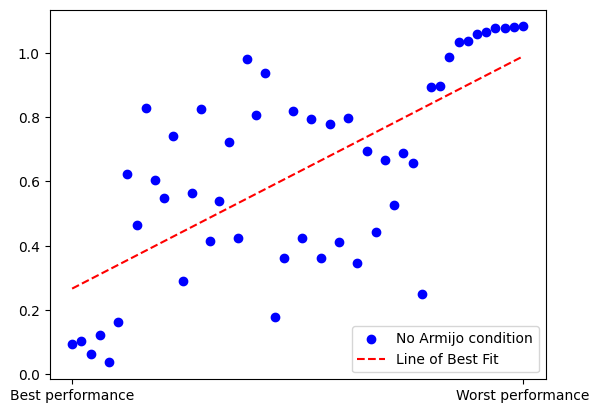

In [19]:
make_dataframe()

In [ ]:
%%ipytest
def test_gradient_descent_2D():
    def h(x): return x*x
    def h_grad(x): return 2*x
    x0 = 10
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent_2D(x0, h, h_grad, alpha, epsilon, max_iter)
    assert round(x) == 0

def test_gradient_descent_2D_linear():
    def h(x): return 2*x
    def h_grad(x): return 2
    x0 = 10
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent_2D(x0, h, h_grad, alpha, epsilon, max_iter)
    assert x == None
    assert i == max_iter

def test_gradient_descent_2D_func_with_two_mins_1():
    def h(x): return np.power(x, 4) - 2*np.power(x, 3) - np.power(x, 2) + 2*x
    def h_grad(x): return 4*np.power(x, 3) - 6*np.power(x, 2) - 2*x + 2
    x0 = 2
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent_2D(x0, h, h_grad, alpha, epsilon, max_iter)
    assert round(x, 1) == 1.6

def test_gradient_descent_2D_func_with_two_mins_2():
    def h(x): return np.power(x, 4) - 2*np.power(x, 3) - np.power(x, 2) + 2*x
    def h_grad(x): return 4*np.power(x, 3) - 6*np.power(x, 2) - 2*x + 2
    x0 = -1
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent_2D(x0, h, h_grad, alpha, epsilon, max_iter)
    assert round(x, 1) == -0.6

UsageError: Cell magic `%%ipytest` not found.
